In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import random

In [31]:
#import and show CSV file
df = pd.read_csv('./CSV/sg_revenue_data.csv')
df.head(5)

,Date,Small Group
0,12/1/2009,2740735
1,1/1/2010,2416148
2,2/1/2010,2547528
3,3/1/2010,2737315
4,4/1/2010,2547421


In [32]:
ts = df.set_index('Date')

In [33]:
ts['Small Group'] = ts['Small Group'].astype(float)

In [34]:
#convert data to array
TS = np.array(ts)
num_periods = 20
f_horizon = 1

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

5
(5, 20, 1)
[[[2740735.]
  [2416148.]
  [2547528.]
  [2737315.]
  [2547421.]
  [2332692.]
  [2675896.]
  [2490901.]
  [2505415.]
  [2401032.]
  [2368470.]
  [2398938.]
  [2394879.]
  [2505553.]
  [2439879.]
  [2473087.]
  [2352302.]
  [2315070.]
  [2445746.]
  [2299619.]]

 [[2516211.]
  [2308152.]
  [2258030.]
  [2294585.]
  [9561070.]
  [2418334.]
  [2381271.]
  [2428115.]
  [2356513.]
  [2404503.]
  [2354231.]
  [2474782.]
  [2486525.]
  [2355672.]
  [2538862.]
  [2423994.]
  [2463172.]
  [2551140.]
  [2434296.]
  [2635361.]]]
[[[2416148.]
  [2547528.]
  [2737315.]
  [2547421.]
  [2332692.]
  [2675896.]
  [2490901.]
  [2505415.]
  [2401032.]
  [2368470.]
  [2398938.]
  [2394879.]
  [2505553.]
  [2439879.]
  [2473087.]
  [2352302.]
  [2315070.]
  [2445746.]
  [2299619.]
  [2516211.]]]
(5, 20, 1)


In [35]:
#pull out test data
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods)
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[7029041.]
  [6823416.]
  [7053886.]
  [6590921.]
  [7043652.]
  [6807451.]
  [6900873.]
  [6995607.]
  [6747183.]
  [6991572.]
  [6884088.]
  [7225003.]
  [7318510.]
  [7183043.]
  [7324757.]
  [7300850.]
  [7475595.]
  [7261327.]
  [7631457.]
  [7342751.]]]


In [63]:
tf.reset_default_graph()

num_periods = 20
inputs = 1
hidden = 2000
output = 1

#create variables
X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

#create RNN object
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

#change form to tensor / specify type of layer / shape of results
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [66]:
#implement model on training data
epochs = 500

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 ==0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 445003070000000.0
100 	MSE: 82766250000000.0
200 	MSE: 56793267000000.0
300 	MSE: 48426503000000.0
400 	MSE: 40826500000000.0
[[[6851661.5]
  [6954800.5]
  [7121407. ]
  [8625553. ]
  [7465746.5]
  [7298954. ]
  [7150549. ]
  [6969235. ]
  [7070919. ]
  [6976296. ]
  [7031065.5]
  [7563493.5]
  [7258132. ]
  [7360542.5]
  [7435005. ]
  [7319544. ]
  [7559668. ]
  [7546006. ]
  [7624912. ]
  [7735858. ]]]


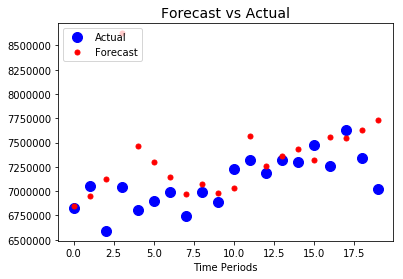

In [67]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label = "Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()